In [2]:
import os
import imageio
from PIL import Image
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from DataLoading import DataLoad
from EncoderCVAE import CVAE_Encoder
from DecoderCVAE import CVAE_Decoder
from Loss import get_loss
from TrainerConstruct import Trainer
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [3]:
# CHANGE THE ENCODER PATH
ENCODER_PATH = 'CVAEresult/cvae_encoder_20250411_154917.pth'

# CHANGE THE PATH IF DATA CHANGE
DATASET_PATH = "./Data/images_original"

# KEEP THE LATENT SPACE SIZE THE SAME UNLESS MODEL ARCH CHENGES
LATENT_SPACE_SIZE = 128 

# CHOOSE THE GENRE YOU ARE INTERESTED IN
class1 = "blues"
class2 = "classical"

classes = ['blues', 'classical', 'country', 'disco', 
 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [14]:
def load_model(encoder_path):
    encoder = CVAE_Encoder(latent_dim=LATENT_SPACE_SIZE, condition_dim=10, input_shape=(3, 128, 128), use_embedding=False)
    encoder.load_state_dict(torch.load('CVAEresult/cvae_encoder_20250411_154917.pth'))
    encoder.eval()
    return encoder

In [15]:
def prepare_data(DATASET_PATH):
    dx, dy = 0, 0
    dimx, dimy = 128, 128
    batch_size = 64
    
    dataload = DataLoad(DATASET_PATH)
    all_photos, all_attrs = dataload.fetch_dataset(dx, dy, dimx, dimy)
    all_photos = np.array(all_photos / 255, dtype='float32')
    
    return all_photos, all_attrs

In [19]:
def encode_images(encoder, images, condition):
    with torch.no_grad():
        images_tensor = torch.from_numpy(images)
        images_tensor = images_tensor.permute(0, 3, 1, 2).float()
        batch_size = images_tensor.shape[0]
        # Repeat the condition vector for each image in the batch.
        condition_tensor = condition.repeat(batch_size, 1)
        mu, logvar, z = encoder(images_tensor, condition_tensor)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z.cpu().numpy()

In [20]:
def latent_space_2d(encoder, data1, label1, data2, label2, classes):
    """Visualize latent space using PCA"""
    condition1 = torch.nn.functional.one_hot(torch.tensor(classes.index(label1)), num_classes=len(classes)).float().unsqueeze(0)
    condition2 = torch.nn.functional.one_hot(torch.tensor(classes.index(label2)), num_classes=len(classes)).float().unsqueeze(0)
    
    data1_encoding = encode_images(encoder, data1, condition1)
    data2_encoding = encode_images(encoder, data2, condition2)
    
    # Flatten the latent vectors if needed (usually they are already [batch, latent_dim]).
    data1_flat = data1_encoding.reshape(data1_encoding.shape[0], -1)
    data2_flat = data2_encoding.reshape(data2_encoding.shape[0], -1)
    
    combined_data = np.vstack((data1_flat, data2_flat))
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(combined_data)
    
    transformed_data1 = transformed_data[:data1_flat.shape[0]]
    transformed_data2 = transformed_data[data1_flat.shape[0]:]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(transformed_data1[:, 0], transformed_data1[:, 1], color='blue', label=label1, alpha=0.5)
    plt.scatter(transformed_data2[:, 0], transformed_data2[:, 1], color='orange', label=label2, alpha=0.5)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"2D PCA of Latent Space for {label1} vs. {label2}")
    plt.legend()
    plt.grid(True)
    plt.show()

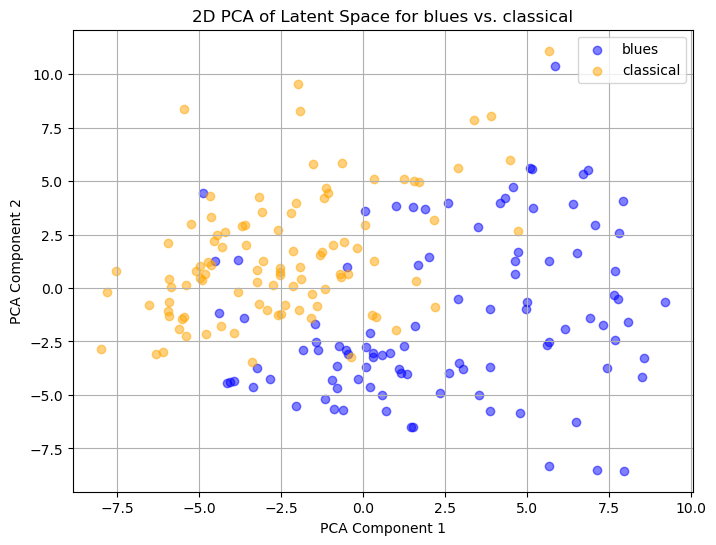

In [21]:
if __name__ == "__main__":
    all_photos, all_attrs = prepare_data(DATASET_PATH)
    encoder = load_model(ENCODER_PATH)
    class1_index = classes.index(class1)
    class2_index = classes.index(class2)
    class1_idx = np.where(all_attrs == class1_index)
    class2_idx = np.where(all_attrs == class2_index)
    
    data1 = all_photos[class1_idx]
    data2 = all_photos[class2_idx]
    
    # Visualize latent space
    latent_space_2d(encoder, data1, class1, data2, class2, classes)